In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
import time 
import keras
from keras import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.metrics import precision_score
from sklearn.metrics import log_loss
import time
from sklearn.metrics import confusion_matrix
%matplotlib inline

Будем работаьт с датасетом, составленным из рукописных "картинок" цифр. Возьмем полную версию датасета - картинки будут размером 28х28, а общее число картинок - 42000. Загрузим датасет и разобъем его на выборки для обучения и контроля. Для ускорения работы возьмем небольшую часть датасета, например, 3%. Отладим на ней код, а потом запустим расчеты на больших данных. Вычисления будут трудоемкими, если брать весь датасет, поэтому для итоговых вычислений будем брать только его часть (40%).

In [127]:
# SAMPLE_FRACTION = .03
SAMPLE_FRACTION = .4

def load_data():
    data = pd.read_csv('train.csv')
    data = data.sample(frac=SAMPLE_FRACTION)
    labels = data['label'].values
    digits = data.drop('label', 1).values
    return digits, labels

In [128]:
digits, labels = load_data()
X_train, X_test, y_train, y_test = train_test_split(digits, labels, test_size=0.25)

В качестве базового решения посмотрим на известные нам алгоритмы. Возьмем kNN и Random Forest. Обучим их (гиперпараметры оставим по умолчанию), посчитаем точность и logloss на тестовой выборке. 

Для классификаторов, которые умеют рассчитывать вероятности, [logloss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) вычесляется по следующей формуле :
$$logloss = -\dfrac{1}{N}\sum_{i=1}^N (y_i\log{p_i} + (1-y_i)\log{(1 - p_i)})$$

In [125]:
def classification(classifier, name_classifier):
    start = time.time()
    classifier.fit(X_train, y_train)
    end = time.time()
    fit_time = end - start
    y_true = y_test
    start = time.time()
    y_pred = classifier.predict(X_test)
    end = time.time()
    predict_time = end - start
    y_prob = classifier.predict_proba(X_test)
    print(name_classifier, 'fit_time:', fit_time)
    print(name_classifier, 'predict_time:', predict_time)
    print(name_classifier, 'precision_score:', precision_score(y_true, y_pred, average = 'micro'))
    print(name_classifier, 'logloss in', log_loss(y_true, y_prob))


In [47]:
random_forest = RandomForestClassifier(random_state = 1)
knn = KNeighborsClassifier()
classification(random_forest, 'Random Forest')
classification(knn, 'kNN')

Random Forest fit_time: 0.9160201549530029
Random Forest predict_time: 0.03983592987060547
Random Forest precision_score: 0.917857142857
Random Forest logloss in 0.64699235102
kNN fit_time: 1.3131308555603027
kNN predict_time: 77.69097805023193
kNN precision_score: 0.945714285714
kNN logloss in 0.567190213484


На 40% датасета по точности и по logloss лучше сработал алгоритм kNN без подбора параметров, чем Random Forest, хотя предсказывал kNN существенно дольше (и обучался немного дольше).  

Далее целевой метрикой для нас будет logloss. Точность также будем вычислять, как более интерпретируемую метрику.

### XGBoost

Усталовим бублиотеку [xgboost.](https://xgboost.readthedocs.io/en/latest/build.html) Реализация бустинга есть и в sklearn, но в ней уделено сильно меньше внимания регуляризации и скорости, поэтому мы будем использовать xgboost. 

Возьмем классификатор с настройками по умолчанию. Установим nthread (n_jobs) на -1 для ускорения расчета. Документацию можно найти [тут](http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier).

In [50]:
xgboost_classifier = XGBClassifier(nthread = - 1)

Обучим его и предскажем метки для тестовой выборки. Выведем logloss, точность классификации и confusion matrix для обученного классификатора. 

In [51]:
classification(xgboost_classifier, 'XGBoost')

XGBoost fit_time: 101.03579521179199
XGBoost predict_time: 0.1419830322265625
XGBoost precision_score: 0.929523809524
XGBoost logloss in 0.267124512232
XGBoost confusion_matrix:  [[410   1   1   0   0   1   3   0   7   0]
 [  0 439   1   4   1   0   2   2   1   0]
 [  3   7 386   4   5   0   7   7   5   3]
 [  1   0   5 433   2  10   0   1   6   3]
 [  1   1   1   0 356   2   4   0   3  15]
 [  2   3   1  14   4 367   6   1   5   4]
 [  4   1   1   0   0   6 398   0   4   0]
 [  2   2  11   2   6   2   0 407   4  10]
 [  2   9   2   9   2   2   2   1 344  11]
 [  1   5   2   2  16   6   0   8   1 364]]


В сумме время обучения и время предсказания у алгоритма XGBoost больше, чем у алгоритмов kNN и Random Forest, однако стоит отметить, что XGBoost долго обучался, а предсказывал относительно быстро. Точность этого алгоритма получилась немного меньше, чем у алгоритма kNN, но функция потерь logloss примерно в два раза меньше, что хорошо. Классификатор склонен давать больше ошибок на некоторых классах, что можно увидеть из confusion matrix. 

[Визуализируем](https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib) важность признаков (feature importances) на картинке 28х28. 

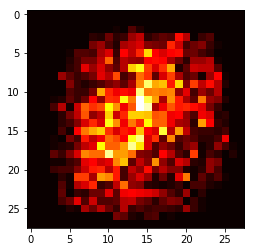

In [73]:
# https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib
xgb_data = xgboost_classifier.feature_importances_
feature_importances = [xgb_data[x:x+28] for x in range(0, len(xgb_data), 28)]
plt.imshow(feature_importances, cmap='hot', interpolation='nearest')
plt.show()


Самые важные пиксели для классификации расположены в центре изображения, потому что они несут основную информацию о том, какая цифра написана на картинке (цифры обычно располагаются в центре изображения). Пиксели по краям не несут информации, потому что они должны быть одинаковыми на всех изображениях. 

Попробуем потюнить XGBoost.

Выберем относительно большую learning_rate ($\eta\in[0.05,0.3]$), подберем оптимальное число деревьев для выбранного $\eta$. В методе `fit` зададим `eval_metric`, равное `mlogloss`, в `eval_set` передадим `[(X_test, y_test)]`; таким образом, мы сможем получать качество классификации после каждого обученного базового классификатора. Можно регулировать "болтливость" метода обучения с помощью параметры `verbose` (например, задать его равным 10).

In [116]:
mean_mlogloss = []
for n in np.arange(1, 1000, 100):
    xgboost_classifier_tune = XGBClassifier(nthread = - 1, learning_rate = 0.2, n_estimators = n)
    xgboost_classifier_tune.fit(X_train, y_train, eval_metric = 'mlogloss', 
                                eval_set = [(X_test, y_test)], verbose = None)
    mean_mlogloss.append(np.asarray(xgboost_classifier_tune.evals_result()['validation_0']['mlogloss']).mean())

Построим график зависимости качества классификации от числа базовых классификаторов (для этого можете воспользоваться методом `evals_result`). 

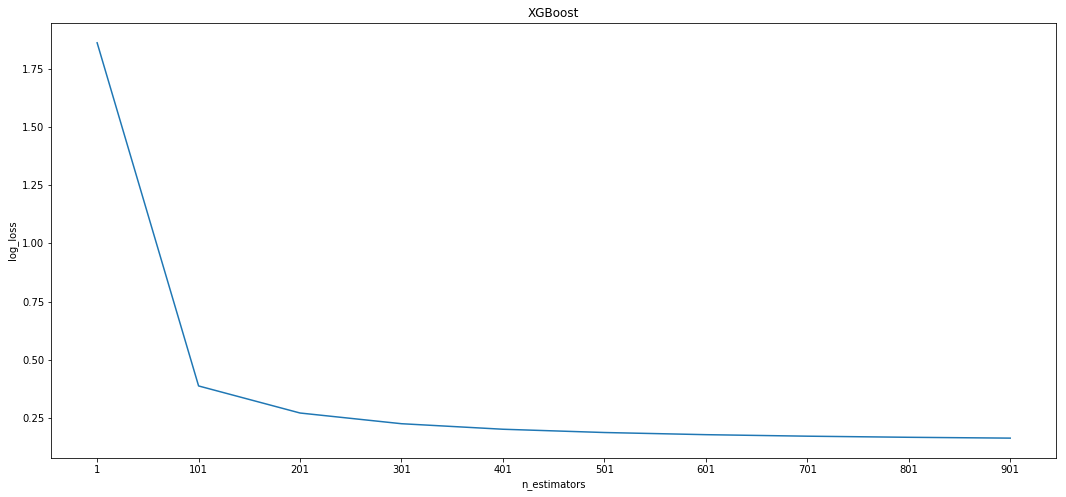

In [117]:
plt.figure(figsize=(18, 8))
plt.plot(np.arange(1, 1000, 100), mean_mlogloss)
plt.xticks(np.arange(1, 1000, 100))
plt.title('XGBoost')
plt.ylabel('log_loss')
plt.xlabel('n_estimators');
    

График зависимости log_loss плавно вышел на плато примерно после n_estimators = 500, хотя нехначительное уменьшение log_loss наблюдается и после этого значения. Но поскольку время работы алгоритма велико, я не стала брать большие значения n_estimators. 

Зафиксируем количество деревьев равным 500. Настроим параметры деревьев, начиная с самых значимых (`max_depth`, `min_child_weight`, `gamma`, `colsample_bytree`).

Правильно подбирать эти параметры по сетке, но данный перебор был бы чересчур трудоемким. Поэтому будем подбирать их последовательно.

In [124]:
mean_mlogloss = []
for n in np.arange(1, 6, 1):
    xgboost_classifier_tune = XGBClassifier(nthread = - 1, learning_rate = 0.2, n_estimators = 500, max_depth = n)
    xgboost_classifier_tune.fit(X_train, y_train, eval_metric = 'mlogloss', 
                                eval_set = [(X_test, y_test)], verbose = None)
    mean_mlogloss.append(np.asarray(xgboost_classifier_tune.evals_result()['validation_0']['mlogloss']).mean())

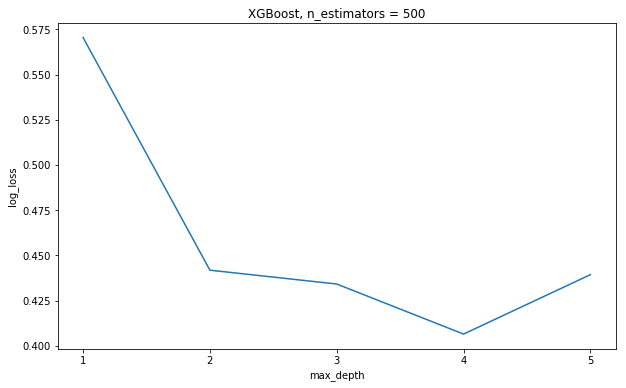

In [123]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 6, 1), mean_mlogloss)
plt.xticks(np.arange(1, 6, 1))
plt.title('XGBoost, n_estimators = 500')
plt.ylabel('log_loss')
plt.xlabel('max_depth');

Для 40% датасета алгоритм за всю ночь не смог построить этот график, поэтому этот график для 3% датасета. Оптимальным значением по нему можно считать max_depth = 4. 

In [129]:
xgboost_classifier_tune = XGBClassifier(nthread = - 1, learning_rate = 0.2, n_estimators = 500, max_depth = 4)
classification(xgboost_classifier_tune, 'XGBoost')

XGBoost fit_time: 568.3178749084473
XGBoost predict_time: 0.9059948921203613
XGBoost precision_score: 0.959523809524
XGBoost logloss in 0.131661525823


Для 40% датасета max_depth = 4 не подходит, потому что качество получилось ниже, чем с max_depth по умолчанию. 

Так как все считается очень долго, а неделя зачетная, я пока остановилась на этом в выполнении данного прака. 